In [1]:
import os
import torch
import numpy as np

os.chdir("C:/Users/Eurhope/Desktop/Diffusion-Distillation-WL")
from Engine.trainer import Engine
from Utils.metric_utils import visualization
from Datasets.create_dataloader import create_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config, build_from_teacher
from Utils.fix_tensors import clean_keys, reshape_tensors
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one
from Graphs.tsplots import * 
from Utils.Data_utils.real_datasets import reconstruct_data, getids
from Models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one


In [ ]:
class Args_Example:
    def __init__(self) -> None:
        self.gpu = 0
        self.config_path = './Configs/sines.yaml'
        self.save_dir = './toy_exp'
        self.mode = 'infill'
        self.missing_ratio = 0.5
        self.milestone = 10
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = create_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
teacher = Engine(config=configs, args=args, model=model, dataloader=dl_info)

teacher.load(args.milestone)

In [3]:
#Plot the original time series
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
datacut = np.load(os.path.join(dataset.dir, f"sine_ground_truth_24_train.npy")) #Stock

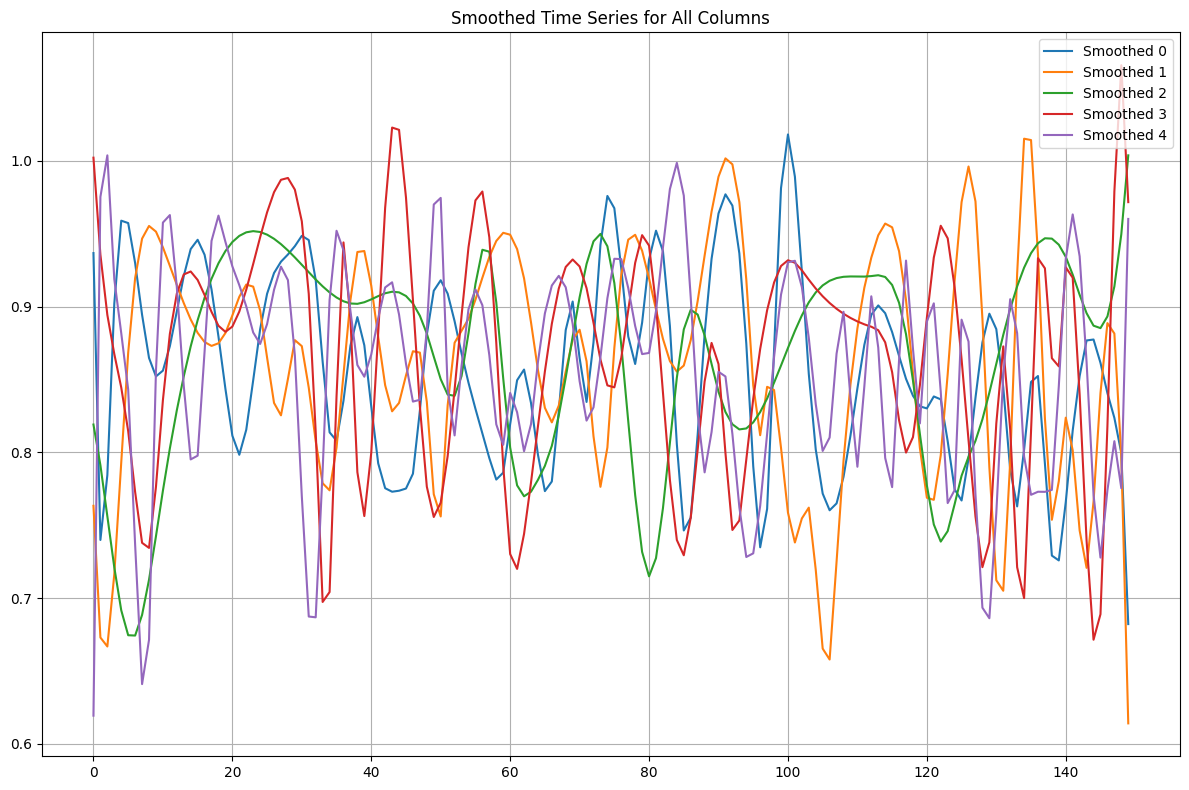

In [5]:
#Plot the original time series

ory = torch.from_numpy(datacut).to(torch.float32).to(teacher.device) #Models have not seen this data in training

regular_train_id = getids(datacut, seed= 123)
orit = reconstruct_data(datacut, regular_train_id)
orit = invert_windows(orit)

plot_smoothed_ts(orit[200:350])

In [ ]:
#Get the Diffusion TS fully trained model; 
configs['model']['target'] = 'Models.interpretable_diffusion.diffusion_ts.Diffusion_FS'
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = create_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
teacher_TS = Engine(config=configs, args=args, model=model, dataloader=dl_info)

teacher_TS.load(100) #100 is the TS model

In [7]:
#Get the data in the correct format to be passed through the transformers; 
ors = normalize_to_neg_one_to_one(ory) 

In [8]:
#Get data from Diffusion_WL and Diffusion_TS
trend_wl, season_wl, residual_wl, noised_data = teacher.model.return_components(ors, 80)

trend, season, residual, noised_data = teacher_TS.model.return_components(ors, 80)

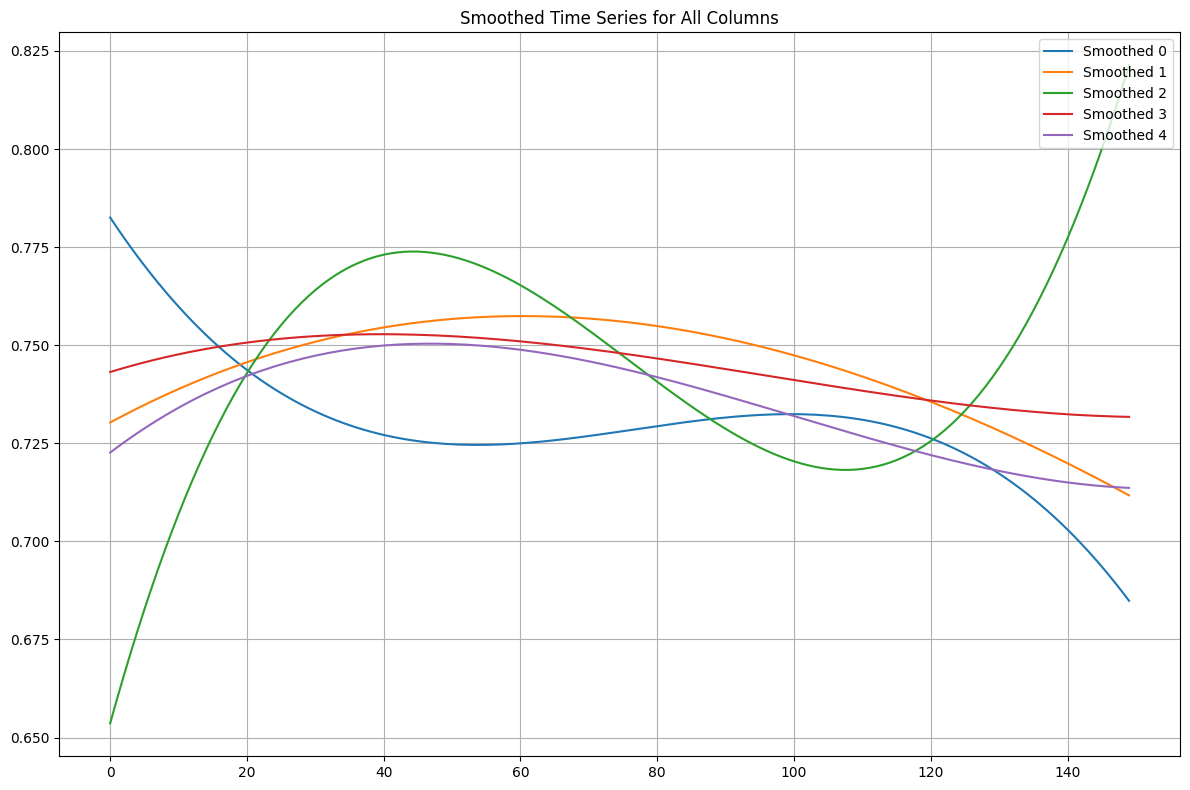

In [13]:
#Argument to be made: in general diffusion WL is better at capturing seasonal "spykes" in the data; the seasonal spykes of Diffusion-WL are often 'larger'
#Which results in more accurate representations when the Seasonal patterns of the data are stronger. 

wl = trend_wl
wl = invert_windows(wl.detach().cpu().numpy()) 

wl = unnormalize_to_zero_to_one(wl)
regular_train_id = getids(wl, seed= 123)

rec = reconstruct_data(wl, regular_train_id) #(Regular_train_id is the permutation of the data with seed 123)

plot_smoothed_ts(rec[200:350]) #Plot of the trend Component 

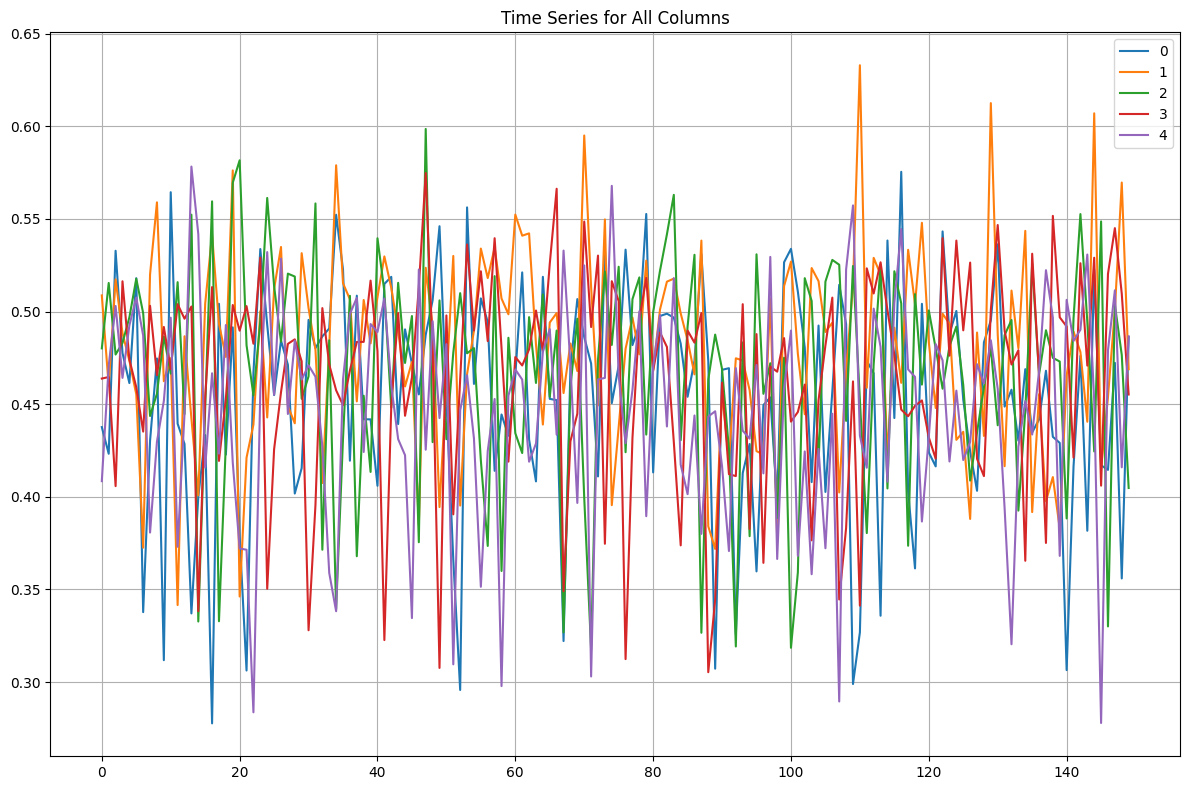

In [14]:
ts = ors - trend
ts= invert_windows(ts.detach().cpu().numpy()) 

ts= unnormalize_to_zero_to_one(ts)
regular_train_id = getids(ts, seed= 123)

rec = reconstruct_data(ts, regular_train_id) #(Regular_train_id is the permutation of the data with seed 123)

plot_ts(rec[200:350]) #Plot of original data de-trended (Diff-TS)

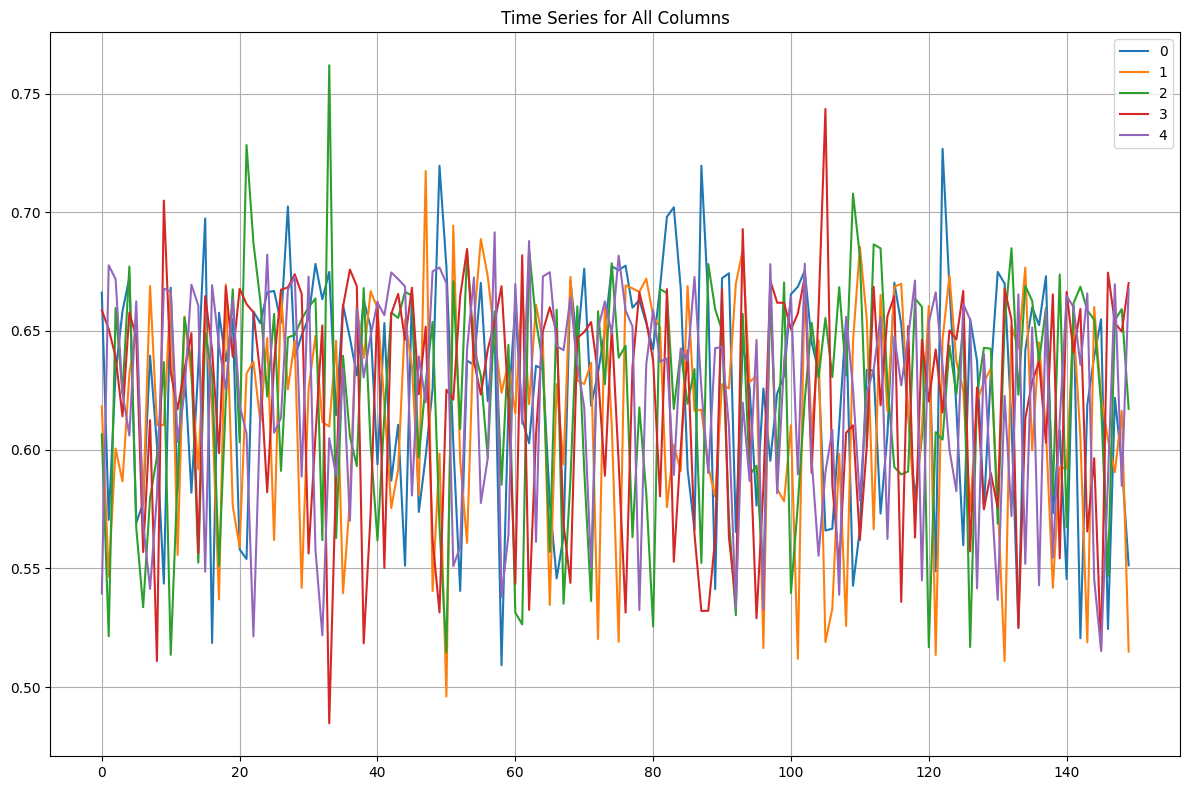

In [15]:
ts = ors - trend_wl
ts= invert_windows(ts.detach().cpu().numpy()) 

ts= unnormalize_to_zero_to_one(ts)
regular_train_id = getids(ts, seed= 123)

rec = reconstruct_data(ts, regular_train_id) #(Regular_train_id is the permutation of the data with seed 123)

plot_ts(rec[200:350]) #Plot of original data de-trended (Diff-WL)

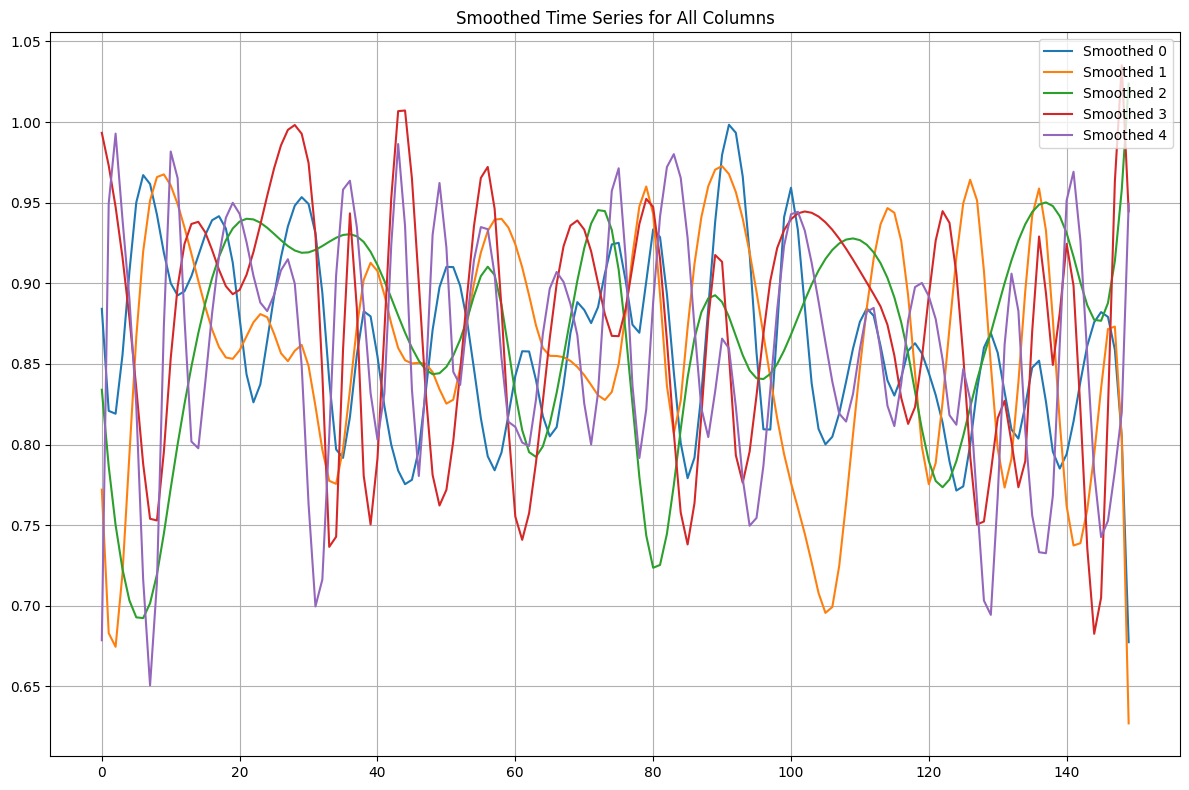

In [16]:
#Plot of re-constructed Data (Diffusion-TS)
ts = season + trend + residual
ts= invert_windows(ts.detach().cpu().numpy()) 

ts= unnormalize_to_zero_to_one(ts)
regular_train_id = getids(ts, seed= 123)

rec = reconstruct_data(ts, regular_train_id) #(Regular_train_id is the permutation of the data with seed 123)

plot_smoothed_ts(rec[200:350]) #Plot of original data de-trended (Diff-TS)

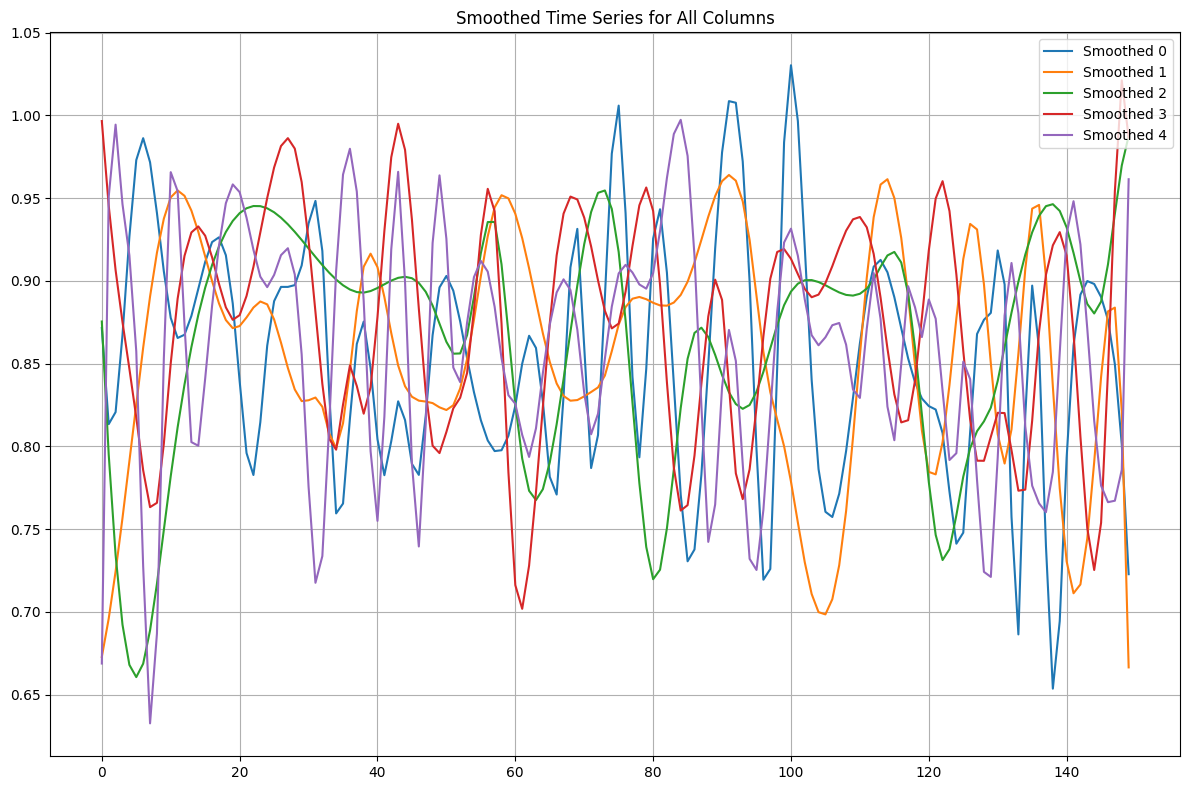

In [17]:
#Plot of re-constructed Data (Diffusion-WL)

ts = season_wl + trend_wl + residual_wl
ts= invert_windows(ts.detach().cpu().numpy()) 

ts= unnormalize_to_zero_to_one(ts)
regular_train_id = getids(ts, seed= 123)

rec = reconstruct_data(ts, regular_train_id) #(Regular_train_id is the permutation of the data with seed 123)

plot_smoothed_ts(rec[200:350]) #Plot of original data de-trended (Diff-TS)